In [43]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import random
import sys, gc, time
import os

# data
import datetime
import itertools
import json
import pickle

# sklearn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler #StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# keras
#from keras_models import create_model17EN1EN2emb1, create_model17noEN1EN2, create_model17

# model
import lightgbm as lgb
from bayes_opt import BayesianOptimization

## LSTM용 데이터 (스케일링 o)

In [46]:
np.random.seed(602)

## 파일경로 고치기
df_wd_lag = pd.read_pickle('C:/Users/secre/Desktop/bigcon_fake/train_fin_wd_lag.pkl') 

## 아래도 자기 컴터에 맞게 고치기
from preprocess import load_df_added, drop_useless, check_na, na_to_zeroes, run_label_all, remove_outliers, drop_cat, run_stdscale, run_pca

df_wd_lag = df_wd_lag.drop(columns = ['lag_sales_wk_1','lag_sales_wk_2'])

data_list = ['df_wk_lag','df_wk_no_lag','df_wd_lag','df_wd_no_lag','df_all_lag']

lag_col1 = ['lag_scode_count','lag_mcode_price','lag_mcode_count','lag_bigcat_price','lag_bigcat_count',
            'lag_bigcat_price_day','lag_bigcat_count_day','lag_small_c_price','lag_small_c_count']

lag_col2 = ['rolling_mean_7', 'rolling_mean_14', 'lag_sales_wd_1', 'lag_sales_wd_2','lag_sales_wd_3',
            'lag_sales_wd_4', 'lag_sales_wd_5', 'lag_sales_wk_1','lag_sales_wk_2', 'ts_pred', 'rolling_mean_mcode', 'rolling_mean_mcode_7', 'rolling_mean_mcode_14']

num_col = ['판매단가','lag_scode_count','lag_mcode_price','lag_mcode_count','lag_bigcat_price','lag_bigcat_count',  'lag_bigcat_price_day',
           'lag_bigcat_count_day',  'lag_small_c_price', 'lag_small_c_count', 'lag_all_price_show', 'lag_all_price_day', 'mid_click_r',
            'big_click_r', 'temp_diff_s', 'age30_small', 'age40_small', 'age50_small', 'age60above_small', 'age30_middle', 'age40_middle',
            'age50_middle', 'age60above_middle', 'age30_big', 'age40_big', 'age50_big', 'age60above_big', 'pc_small', 'mobile_small',
            'pc_middle', 'mobile_middle', 'pc_big', 'mobile_big', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_mcode_7', 'rolling_mean_mcode_14',
            'lag_sales_wd_1', 'lag_sales_wd_2', 'lag_sales_wd_3', 'lag_sales_wd_4', 'lag_sales_wd_5', 'ts_pred']

cat_col = ['상품군','weekdays','small_c','middle_c','big_c',
                        'pay','months','hours_inweek','weekends','japp','parttime',
                        'min_start','primetime','prime_origin','prime_smallc',
                        'freq','bpower','steady','men','pay','luxury',
                        'spring','summer','fall','winter','rain']
#cat_col2 = ['상품군','weekdays','small_c','middle_c','big_c',
#                        'pay','months','hours_inweek','weekends','japp','parttime',
#                        'min_start','primetime','prime_origin','prime_smallc',
#                        'freq','bpower','steady','men','pay','luxury',
#                        'spring','summer','fall','winter','rain',
#          'exposed_t','dup_times','dup_times_smallc']

len(lag_col1)
len(cat_col)

check_na(df_wd_lag.iloc[:,40:63])

## simple function that will be used for run_preprocess
def na_to_zeroes(df):
    """
    :objective: Change all na's to zero.(just for original lag!)
    :return: pandas dataframe
    """
    xcol = [x for x in df.columns if x in lag_col1+lag_col2]
    for col in xcol:
        df[col] = df[col].fillna(0)

    return df

def drop_cat(df_pca):
    """
    :objective: Before PCA, drop categorical variables
    :return: pandas dataframe
    """
    xcol = [x for x in df_pca.columns if x in cat_col+lag_col2]
    df_pca = df_pca.drop(columns = xcol)
    df_pca = df_pca.drop(columns = '취급액')

    return df_pca


def run_pca(df_pca_scaled, n_components = 5):
    """
    :objective: Run PCA with n_components = 5
    :return: pandas dataframe
    """
    pca = PCA(n_components = 5)
    pca.fit(df_pca_scaled)
    df_pca = pca.transform(df_pca_scaled)

    return df_pca

## run preprocessing in a shot
## pca is optional and only applied to numeric features other than 'lag'
## NOTICE: removing outliers were run prior to dividing train/val
## if replace = True, new PCA will replace corresponding numerical columns
## if you want to simply add PCA columns to original data, set replace = False
def run_preprocess(df, pca = True, replace = True):
    """
    :objective: Run Feature deletion, NA imputation, label encoding, pca(optional)
    :return: pandas dataframe
    """
    df = drop_useless(df)
    df = na_to_zeroes(df)
    df = remove_outliers(df)
    df = run_label_all(df)
    df1 = df.copy()
    if pca:
        xcol = [x for x in df1.columns if x in cat_col+lag_col2]
        df_pca = df1.copy()
        df_pca = drop_cat(df_pca).copy()
        df_pca = run_stdscale(df_pca)
        df_pca = run_pca(df_pca)
        if replace:
            df_pca1 = pd.concat([df1[xcol], pd.DataFrame(df_pca)], axis=1)
            return df_pca1
        else:
            df_pca2 = pd.concat([df1, pd.DataFrame(df_pca)], axis=1)
            return df_pca2
    else:
        return df1

## Preprocessed datasets
df_wd_lag = run_preprocess(df_wd_lag, pca = True, replace =False)

#df_wd_lag_PP.to_csv ('df_wd_lag_PP.csv', index = False, header=True,encoding='ms949')
#df_wd_no_lag_PP.to_csv ('df_wd_no_lag_PP.csv', index = False, header=True,encoding='ms949')

df_wd_lag = df_wd_lag.iloc[:,1:]
df_wd_lag = df_wd_lag.drop('show_id', axis=1)

scaler = StandardScaler()

for i in num_col:
    df_wd_lag[i] = scaler.fit_transform(df_wd_lag[i].values.reshape(-1,1))
    
sales_mean = df_wd_lag.취급액.values.mean()
sales_sd = df_wd_lag.취급액.values.std()
df_wd_lag.취급액 = (df_wd_lag.취급액 - sales_mean)/sales_sd

########################### Divide into train/val
###############################################################################
train_wd_lag_x = df_wd_lag.iloc[:16904,:].drop('취급액', axis=1)
train_wd_lag_y = df_wd_lag.iloc[:16904,:].취급액
val_wd_lag_x = df_wd_lag.iloc[16904:,:].drop('취급액', axis=1)
val_wd_lag_y = df_wd_lag.iloc[16904:,:].취급액

lag_mcode_count         6266
lag_bigcat_price          60
lag_bigcat_count          60
lag_bigcat_price_day    2996
lag_bigcat_count_day    2996
lag_small_c_price       3124
lag_small_c_count       3124
lag_all_price_show         0
lag_all_price_day          0
bpower                     0
steady                     0
men                        0
luxury                     0
pay                        0
spring                     0
summer                     0
fall                       0
winter                     0
small_click_r              0
mid_click_r                0
big_click_r                0
rain                       0
temp_diff_s                0
dtype: int64


## LGBM용 데이터 (스케일링x)

In [47]:
np.random.seed(602)

## 파일경로 고치기
df_wd_lag2 = pd.read_pickle('C:/Users/secre/Desktop/bigcon_fake/train_fin_wd_lag.pkl') 

## 아래도 자기 컴터에 맞게 고치기
from preprocess import load_df_added, drop_useless, check_na, na_to_zeroes, run_label_all, remove_outliers, drop_cat, run_stdscale, run_pca

df_wd_lag2 = df_wd_lag2.drop(columns = ['lag_sales_wk_1','lag_sales_wk_2'])

data_list = ['df_wk_lag','df_wk_no_lag','df_wd_lag','df_wd_no_lag','df_all_lag']

lag_col1 = ['lag_scode_count','lag_mcode_price','lag_mcode_count','lag_bigcat_price','lag_bigcat_count',
            'lag_bigcat_price_day','lag_bigcat_count_day','lag_small_c_price','lag_small_c_count']

lag_col2 = ['rolling_mean_7', 'rolling_mean_14', 'lag_sales_wd_1', 'lag_sales_wd_2','lag_sales_wd_3',
            'lag_sales_wd_4', 'lag_sales_wd_5', 'lag_sales_wk_1','lag_sales_wk_2', 'ts_pred', 'rolling_mean_mcode', 'rolling_mean_mcode_7', 'rolling_mean_mcode_14']

num_col = ['판매단가','lag_scode_count','lag_mcode_price','lag_mcode_count','lag_bigcat_price','lag_bigcat_count',  'lag_bigcat_price_day',
           'lag_bigcat_count_day',  'lag_small_c_price', 'lag_small_c_count', 'lag_all_price_show', 'lag_all_price_day', 'mid_click_r',
            'big_click_r', 'temp_diff_s', 'age30_small', 'age40_small', 'age50_small', 'age60above_small', 'age30_middle', 'age40_middle',
            'age50_middle', 'age60above_middle', 'age30_big', 'age40_big', 'age50_big', 'age60above_big', 'pc_small', 'mobile_small',
            'pc_middle', 'mobile_middle', 'pc_big', 'mobile_big', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_mcode_7', 'rolling_mean_mcode_14',
            'lag_sales_wd_1', 'lag_sales_wd_2', 'lag_sales_wd_3', 'lag_sales_wd_4', 'lag_sales_wd_5', 'ts_pred','취급액']

cat_col = ['상품군','weekdays','small_c','middle_c','big_c',
                        'pay','months','hours_inweek','weekends','japp','parttime',
                        'min_start','primetime','prime_origin','prime_smallc',
                        'freq','bpower','steady','men','pay','luxury',
                        'spring','summer','fall','winter','rain']
#cat_col2 = ['상품군','weekdays','small_c','middle_c','big_c',
#                        'pay','months','hours_inweek','weekends','japp','parttime',
#                        'min_start','primetime','prime_origin','prime_smallc',
#                        'freq','bpower','steady','men','pay','luxury',
#                        'spring','summer','fall','winter','rain',
#          'exposed_t','dup_times','dup_times_smallc']

len(lag_col1)
len(cat_col)

check_na(df_wd_lag2.iloc[:,40:63])

## simple function that will be used for run_preprocess
def na_to_zeroes(df):
    """
    :objective: Change all na's to zero.(just for original lag!)
    :return: pandas dataframe
    """
    xcol = [x for x in df.columns if x in lag_col1+lag_col2]
    for col in xcol:
        df[col] = df[col].fillna(0)

    return df

def drop_cat(df_pca):
    """
    :objective: Before PCA, drop categorical variables
    :return: pandas dataframe
    """
    xcol = [x for x in df_pca.columns if x in cat_col+lag_col2]
    df_pca = df_pca.drop(columns = xcol)
    df_pca = df_pca.drop(columns = '취급액')

    return df_pca


def run_pca(df_pca_scaled, n_components = 5):
    """
    :objective: Run PCA with n_components = 5
    :return: pandas dataframe
    """
    pca = PCA(n_components = 5)
    pca.fit(df_pca_scaled)
    df_pca = pca.transform(df_pca_scaled)

    return df_pca

## run preprocessing in a shot
## pca is optional and only applied to numeric features other than 'lag'
## NOTICE: removing outliers were run prior to dividing train/val
## if replace = True, new PCA will replace corresponding numerical columns
## if you want to simply add PCA columns to original data, set replace = False
def run_preprocess(df, pca = True, replace = True):
    """
    :objective: Run Feature deletion, NA imputation, label encoding, pca(optional)
    :return: pandas dataframe
    """
    df = drop_useless(df)
    df = na_to_zeroes(df)
    df = remove_outliers(df)
    df = run_label_all(df)
    df1 = df.copy()
    if pca:
        xcol = [x for x in df1.columns if x in cat_col+lag_col2]
        df_pca = df1.copy()
        df_pca = drop_cat(df_pca).copy()
        df_pca = run_stdscale(df_pca)
        df_pca = run_pca(df_pca)
        if replace:
            df_pca1 = pd.concat([df1[xcol], pd.DataFrame(df_pca)], axis=1)
            return df_pca1
        else:
            df_pca2 = pd.concat([df1, pd.DataFrame(df_pca)], axis=1)
            return df_pca2
    else:
        return df1

## Preprocessed datasets
df_wd_lag2 = run_preprocess(df_wd_lag2, pca = True, replace =False)

#df_wd_lag_PP.to_csv ('df_wd_lag_PP.csv', index = False, header=True,encoding='ms949')
#df_wd_no_lag_PP.to_csv ('df_wd_no_lag_PP.csv', index = False, header=True,encoding='ms949')

df_wd_lag2 = df_wd_lag2.iloc[:,1:]
df_wd_lag2 = df_wd_lag2.drop('show_id', axis=1)

len(df_wd_lag2)

########################### Divide into train/val
###############################################################################
train_wd_lag_x2 = df_wd_lag2.iloc[:16904,:].drop('취급액', axis=1)
train_wd_lag_y2 = df_wd_lag2.iloc[:16904,:].취급액
val_wd_lag_x2 = df_wd_lag2.iloc[16904:,:].drop('취급액', axis=1)
val_wd_lag_y2 = df_wd_lag2.iloc[16904:,:].취급액

lag_mcode_count         6266
lag_bigcat_price          60
lag_bigcat_count          60
lag_bigcat_price_day    2996
lag_bigcat_count_day    2996
lag_small_c_price       3124
lag_small_c_count       3124
lag_all_price_show         0
lag_all_price_day          0
bpower                     0
steady                     0
men                        0
luxury                     0
pay                        0
spring                     0
summer                     0
fall                       0
winter                     0
small_click_r              0
mid_click_r                0
big_click_r                0
rain                       0
temp_diff_s                0
dtype: int64


## LGBM (그동안 돌렸던 것들 중 젤 결과 잘나온 버전)

In [50]:
result2 = {'feature_fraction': 0.8786,
  'learning_rate': 0.002168,
  'min_data_in_leaf': 106,
  'n_estimators': 3641,
  'num_iterations': 2777,
  'subsample': 0.755,
  'boosting_type': 'dart',
  'objective': 'regression',
  'metric': 'mape',
  'categorical_feature': [3, 9, 10, 11]}

from lightgbm import LGBMRegressor

def metric(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        cc = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return cc

SEED = 42             # Our random seed for everything
random.seed(SEED)     # to make all tests "deterministic"
np.random.seed(SEED)

TARGET = '취급액'      # Our Target

model = LGBMRegressor(**result2)
model.fit(train_wd_lag_x2, train_wd_lag_y2)
preds = model.predict(val_wd_lag_x2)

[LightGBM] [Warning] feature_fraction is set=0.8786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106


In [51]:
print(metric(val_wd_lag_y2, preds))

78.66865735366106


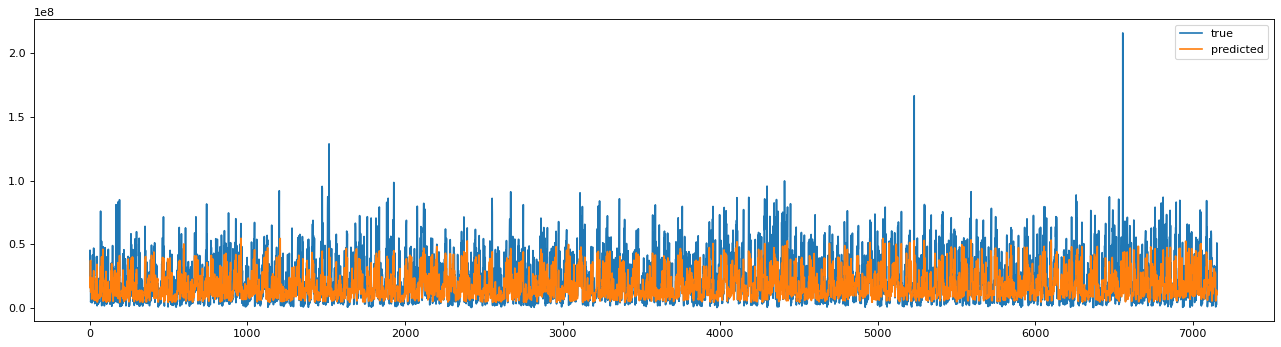

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5),dpi=80)
x = range(0,7156)
plt.plot(x,val_wd_lag_y2, label='true')
plt.plot(x,preds, label='predicted')
plt.legend()
plt.show()

## 그냥 single layer LSTM 돌려보기

In [54]:
train_x = train_wd_lag_x.values.reshape((train_wd_lag_x.shape[0], 1, train_wd_lag_x.shape[1]))
val_x = val_wd_lag_x.values.reshape((val_wd_lag_x.shape[0], 1, val_wd_lag_x.shape[1]))
train_y = train_wd_lag_y.values
val_y = val_wd_lag_y.values

print(train_x.shape, val_x.shape,
      train_y.shape, val_y.shape)

(16904, 1, 76) (7156, 1, 76) (16904,) (7156,)


#### MSE 기준으로 돌렸음!! (MAPE로 돌리면....에바쎄바)

In [79]:
from keras.layers import LSTM, Dense, Dropout, Activation
from keras import Sequential
import tensorflow as tf
from keras import optimizers
from keras.callbacks import ModelCheckpoint

# Setting parameters for model and begin training
epoch = 100
batch = 256
decay = 0 
learning_rate = 0.001
#neurons = 18
dropout = 0.1
output_neurons = 1
version = 0

# Model architecture
model = Sequential()
model.add(LSTM(10, input_shape=(1, train_x.shape[2]), return_sequences=False, name='L1'))

# We could add dropout in layers if model overfits.
model.add(Dropout(dropout,  name='Dro1'))  
model.add(Dense(output_neurons, name='De1'))
# We could add activation function for better learning of model.
#model.add(Activation('relu'))
adam = optimizers.Adam(lr=learning_rate, decay=decay)
model.compile(loss='mean_squared_error', optimizer=adam)

# Using checkpoint to save only 1 model that fits best on validation data.
file_path = "./SimpleLSTM_rmse" \
            + "a.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
history = model.fit(train_x, train_y, batch_size=batch, validation_data=(val_x, val_y), epochs=epoch, verbose=2, callbacks=[checkpoint])

Train on 16904 samples, validate on 7156 samples
Epoch 1/100
 - 1s - loss: 0.9301 - val_loss: 1.0592

Epoch 00001: val_loss improved from inf to 1.05916, saving model to ./SimpleLSTM_rmsea.hdf5
Epoch 2/100
 - 0s - loss: 0.7893 - val_loss: 0.9818

Epoch 00002: val_loss improved from 1.05916 to 0.98183, saving model to ./SimpleLSTM_rmsea.hdf5
Epoch 3/100
 - 0s - loss: 0.7006 - val_loss: 0.9253

Epoch 00003: val_loss improved from 0.98183 to 0.92530, saving model to ./SimpleLSTM_rmsea.hdf5
Epoch 4/100
 - 0s - loss: 0.6290 - val_loss: 0.8526

Epoch 00004: val_loss improved from 0.92530 to 0.85255, saving model to ./SimpleLSTM_rmsea.hdf5
Epoch 5/100
 - 0s - loss: 0.5760 - val_loss: 0.8211

Epoch 00005: val_loss improved from 0.85255 to 0.82108, saving model to ./SimpleLSTM_rmsea.hdf5
Epoch 6/100
 - 0s - loss: 0.5400 - val_loss: 0.7866

Epoch 00006: val_loss improved from 0.82108 to 0.78659, saving model to ./SimpleLSTM_rmsea.hdf5
Epoch 7/100
 - 0s - loss: 0.5148 - val_loss: 0.7653

Epoch 00

 - 0s - loss: 0.3182 - val_loss: 0.7356

Epoch 00074: val_loss did not improve from 0.72357
Epoch 75/100
 - 0s - loss: 0.3184 - val_loss: 0.7408

Epoch 00075: val_loss did not improve from 0.72357
Epoch 76/100
 - 1s - loss: 0.3130 - val_loss: 0.7403

Epoch 00076: val_loss did not improve from 0.72357
Epoch 77/100
 - 0s - loss: 0.3184 - val_loss: 0.7401

Epoch 00077: val_loss did not improve from 0.72357
Epoch 78/100
 - 1s - loss: 0.3163 - val_loss: 0.7514

Epoch 00078: val_loss did not improve from 0.72357
Epoch 79/100
 - 1s - loss: 0.3135 - val_loss: 0.7415

Epoch 00079: val_loss did not improve from 0.72357
Epoch 80/100
 - 1s - loss: 0.3129 - val_loss: 0.7419

Epoch 00080: val_loss did not improve from 0.72357
Epoch 81/100
 - 1s - loss: 0.3143 - val_loss: 0.7228

Epoch 00081: val_loss improved from 0.72357 to 0.72276, saving model to ./SimpleLSTM_rmsea.hdf5
Epoch 82/100
 - 1s - loss: 0.3079 - val_loss: 0.7500

Epoch 00082: val_loss did not improve from 0.72276
Epoch 83/100
 - 1s - lo

### LGBM prediction의 max 값보다 val_y 참값이 더 큰 경우 LSTM 값으로 대체
#### -> 이 threshold에 걸리는 y값들에 해당하는 상품군/판매단가 뭐뭐??

In [80]:
from keras.models import load_model

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_rmse = load_model(file_path)
predicted_rmse = model_rmse.predict(val_x)
val_y_rmse = (val_wd_lag_y * sales_sd) + sales_mean
pred_Model_rmse = (predicted_rmse * sales_sd) + sales_mean


lg = preds
ls = pred_Model_rmse

total = np.zeros(len(val_wd_lag_y2))

for i in range(len(val_wd_lag_y2)) :
    if val_wd_lag_y2.values[i] < np.max(lg):
        total[i] = lg[i]
    else:
        total[i] = ls[i]
             
print(mean_absolute_percentage_error(total, val_wd_lag_y2))

59.05464344171224


In [72]:
## 불안하니까 다른 변수로 또 저장
best = total

array([17476332.93628844, 23808184.2438139 , 15591421.91945559, ...,
       10328854.80835163, 10169440.21470721, 11738534.30185184])

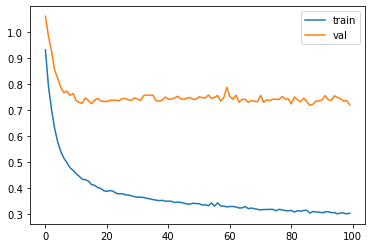

<Figure size 800x640 with 0 Axes>

In [81]:
# Plot epoch loss graph
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.figure(figsize=(10,8),dpi=80)
plt.show()

### LSTM 만

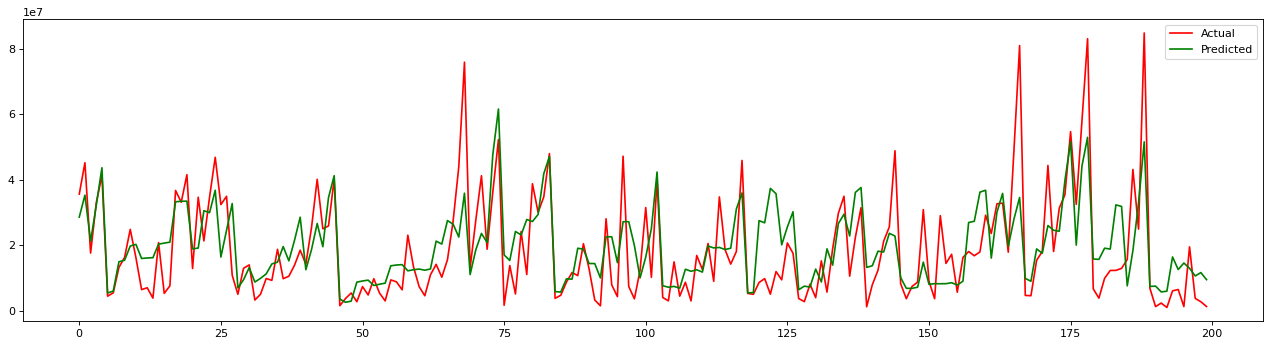

In [82]:
# Load Model
# file_path = "Liquor_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5"
#from keras.models import load_model

#model_rmse = load_model(file_path)
#predicted_rmse = model_rmse.predict(val_x)

# Reconstruct original values
#val_y_rmse = scaler.inverse_transform(val_wd_lag_y.values.reshape(-1,1))
#pred_Model_rmse = scaler.inverse_transform(predicted_rmse)
plt.figure(figsize=(20,5),dpi=80)
x = range(0,200)
plt.plot(x, val_y_rmse[:200], 'r',label='Actual')
plt.plot(x, pred_Model_rmse[:200], 'g', label='Predicted')
plt.legend()
plt.show()

### 그냥 LSTM 만

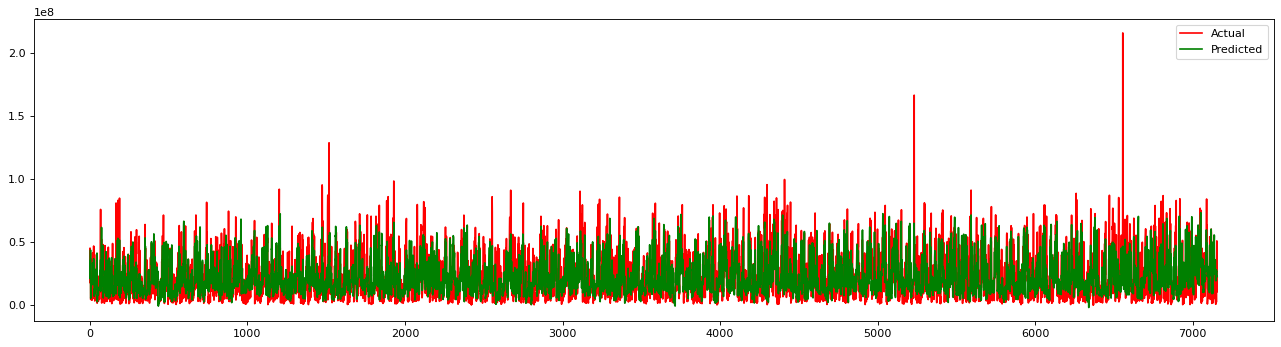

In [83]:
# Load Model
# file_path = "Liquor_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5"
#from keras.models import load_model

#model_rmse = load_model(file_path)
#predicted_rmse = model_rmse.predict(val_x)

# Reconstruct original values
#val_y_rmse = scaler.inverse_transform(val_wd_lag_y.values.reshape(-1,1))
#pred_Model_rmse = scaler.inverse_transform(predicted_rmse)
plt.figure(figsize=(20,5),dpi=80)
x = range(0,7156)
plt.plot(x, val_y_rmse, 'r',label='Actual')
plt.plot(x, pred_Model_rmse, 'g', label='Predicted')
plt.legend()
plt.show()

### LSTM + LGBM

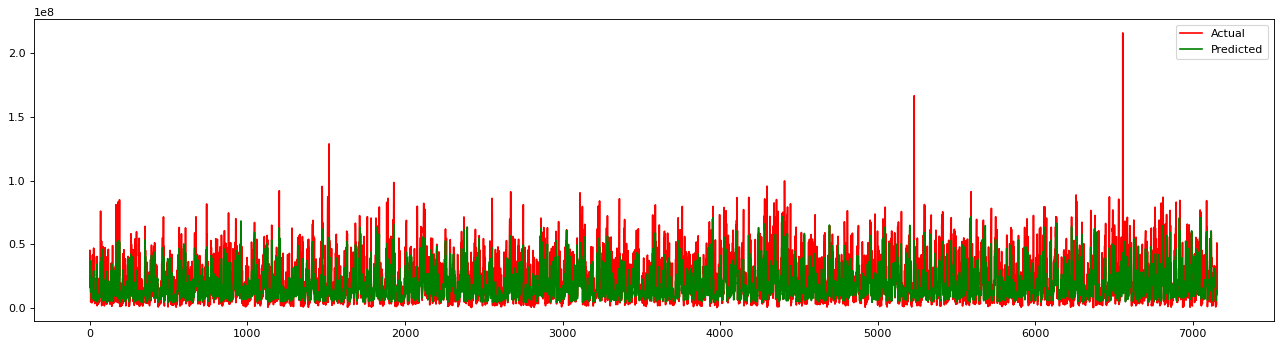

In [84]:
# Load Model
# file_path = "Liquor_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5"
#from keras.models import load_model

#model_rmse = load_model(file_path)
#predicted_rmse = model_rmse.predict(val_x)

# Reconstruct original values
#val_y_rmse = scaler.inverse_transform(val_wd_lag_y.values.reshape(-1,1))
#pred_Model_rmse = scaler.inverse_transform(predicted_rmse)
plt.figure(figsize=(20,5),dpi=80)
x = range(0,7156)
plt.plot(x, val_y_rmse, 'r',label='Actual')
plt.plot(x, total, 'g', label='Predicted')
plt.legend()
plt.show()

### LSTM만

In [78]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(val_y_rmse, pred_Model_rmse))
mape = mean_absolute_percentage_error(val_y_rmse, pred_Model_rmse)
score = r2_score(val_y_rmse, pred_Model_rmse)
print('r2 score for model 1 : ', score)
print('RMSE for model 1 : ', rmse)
print('MAPE for model 1 : ', mape)
print(mean_absolute_error(val_y_rmse, pred_Model_rmse))

r2 score for model 1 :  0.0029967105583564857
RMSE for model 1 :  17818927.96222953
MAPE for model 1 :  186.97027692692245
14038376.69647848
